Renamed 'FID' to 'OBJECTID' in DataFrame.
Initial DataFrame shape: (11132, 12)
Initial DataFrame columns: Index(['OBJECTID', 'Shape', 'Id', 'ORIG_FID', 'code', 'certainty', 'Type',
       'Fault', 'Confidence', 'Shape_Leng', 'POINT_X', 'POINT_Y'],
      dtype='object')
Initial DataFrame OBJECTID range: 0 11131
Missing OBJECTIDs: []
Overall Standard Deviation: 7.475102268468965


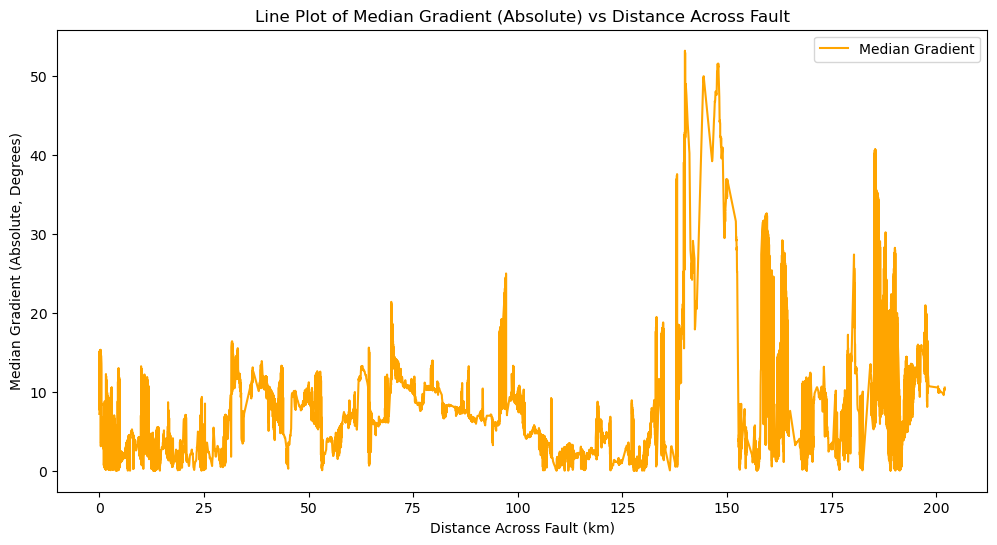

In [25]:
import arcpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# ---------------------------
# CONSTANTS & PATHS
# ---------------------------
# Set your input and output folders.
input_folder = r"C:\Users\Admin\OneDrive - The University of Melbourne\PhD\Github\Manuscripts\2025\AF_StructuralMaturity-ForReview\input_shapefiles"
output_folder = r"C:\Users\Admin\OneDrive - The University of Melbourne\PhD\Github\Manuscripts\2025\AF_StructuralMaturity-ForReview\Corrugation\Outputs"

# Set the workspace to the input folder.
arcpy.env.workspace = input_folder

# Define the spatial reference.
spatial_ref = ('PROJCS["NZGD_2000_New_Zealand_Transverse_Mercator",'
               'GEOGCS["GCS_NZGD_2000",DATUM["D_NZGD_2000",'
               'SPHEROID["GRS_1980",6378137.0,298.257222101]],'
               'PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],'
               'PROJECTION["Transverse_Mercator"],'
               'PARAMETER["False_Easting",1600000.0],'
               'PARAMETER["False_Northing",10000000.0],'
               'PARAMETER["Central_Meridian",173.0],'
               'PARAMETER["Scale_Factor",0.9996],'
               'PARAMETER["Latitude_Of_Origin",0.0],'
               'UNIT["Meter",1.0]]')

# Define the input shapefile (rotated so that the fault is horizontal).
input_shapefile = os.path.join(input_folder, "DAFTs_Rotated.shp")

# Define the output densified shapefile.
densified_shapefile = os.path.join(output_folder, "Trace_Rotated_GeneratePointsAlongLines.shp")

#Define the length of fault to determine window
faultlength = 480 #km

# ---------------------------
# STEP 1: DENSIFY SHAPEFILE TO NODES AND ADD POINT_X AND POINT_Y INFORMATION
# ---------------------------
arcpy.management.GeneratePointsAlongLines(
    Input_Features=input_shapefile,
    Output_Feature_Class=densified_shapefile,
    Point_Placement="DISTANCE",
    Distance="50 Meters",
    Percentage=None,
    Include_End_Points="END_POINTS",
    Add_Chainage_Fields="NO_CHAINAGE",
    Distance_Field=None,
    Distance_Method="PLANAR"
)

arcpy.management.CalculateGeometryAttributes(
    in_features=densified_shapefile,
    geometry_property="POINT_X POINT_X;POINT_Y POINT_Y",
    length_unit="",
    area_unit="",
    coordinate_system=spatial_ref,
    coordinate_format="SAME_AS_INPUT"
)

# ---------------------------
# STEP 2: Create a DataFrame from the Densified Shapefile
# ---------------------------
field_list = [field.name for field in arcpy.ListFields(densified_shapefile)]
array = arcpy.da.FeatureClassToNumPyArray(densified_shapefile, field_list)
df_data = {field: array[field].tolist() if array[field].ndim > 1 else array[field] for field in field_list}
df = pd.DataFrame(df_data, columns=field_list)

# Rename FID to OBJECTID if necessary.
if "OBJECTID" not in df.columns:
    if "FID" in df.columns:
        df = df.rename(columns={"FID": "OBJECTID"})
        print("Renamed 'FID' to 'OBJECTID' in DataFrame.")
    else:
        raise ValueError("Neither OBJECTID nor FID found in DataFrame.")

print("Initial DataFrame shape:", df.shape)
print("Initial DataFrame columns:", df.columns)
print("Initial DataFrame OBJECTID range:", df["OBJECTID"].min(), df["OBJECTID"].max())

# ---------------------------
# STEP 3: Calculate Median Gradient for Each Point
# ---------------------------
# Use a shorter field name "MED_GRAD" instead of "Median_Gradient"
median_gradient_field = "MED_GRAD"
if median_gradient_field not in [field.name for field in arcpy.ListFields(densified_shapefile)]:
    arcpy.AddField_management(densified_shapefile, median_gradient_field, "DOUBLE")

def calculate_gradient(reference_point, nearby_points):
    gradients = []
    for index, row in nearby_points.iterrows():
        dx = row["POINT_X"] - reference_point["POINT_X"]
        dy = row["POINT_Y"] - reference_point["POINT_Y"]
        if dx == 0 and dy == 0:
            continue
        gradient = np.arctan(dy / dx)
        gradients.append(gradient)
    if len(gradients) == 0:
        print("No gradients found.")
        return np.nan
    return np.median(gradients)


lf2 = ((faultlength*1000)*0.02) / 2

for index, reference_point in df.iterrows():
    nearby_points = df[(df["POINT_X"] >= reference_point["POINT_X"] - lf2) &
                       (df["POINT_X"] <= reference_point["POINT_X"] + lf2)]
    median_gradient = calculate_gradient(reference_point, nearby_points)
    df.at[index, median_gradient_field] = median_gradient

missing_ids = []
with arcpy.da.UpdateCursor(densified_shapefile, ["FID", median_gradient_field]) as cursor:
    for row in cursor:
        object_id = row[0]  # This is the FID in the shapefile
        if object_id in df["OBJECTID"].values:
            median_gradient = df.loc[df["OBJECTID"] == object_id, median_gradient_field].values[0]
            row[1] = median_gradient
            cursor.updateRow(row)
        else:
            missing_ids.append(object_id)
print(f"Missing OBJECTIDs: {missing_ids}")


# ---------------------------
# STEP 4: Prepare Data for Plotting
# ---------------------------
df_plot = df.dropna(subset=[median_gradient_field])
df_plot.loc[:, "Median_Gradient_Abs_Deg"] = np.degrees(np.abs(df_plot[median_gradient_field]))
df_plot = df_plot.sort_values(by="POINT_X")
min_point_x = df_plot["POINT_X"].min()
df_plot["POINT_X_Adjusted"] = (df_plot["POINT_X"] - min_point_x) / 1000
overall_standard_deviation = np.std(df_plot["Median_Gradient_Abs_Deg"])
print("Overall Standard Deviation:", overall_standard_deviation)

# ---------------------------
# STEP 5: Plot the Median Gradient vs Distance Across Fault
# ---------------------------
plt.figure(figsize=(12, 6))
plt.plot(df_plot["POINT_X_Adjusted"], df_plot["Median_Gradient_Abs_Deg"],
         linestyle='-', color='orange', label='Median Gradient')
plt.ylabel("Median Gradient (Absolute, Degrees)")
plt.xlabel("Distance Across Fault (km)")
plt.title("Line Plot of Median Gradient (Absolute) vs Distance Across Fault")
plt.legend()

# Save the plot as a PDF with the input shapefile's base name.
input_base = os.path.splitext(os.path.basename(input_shapefile))[0]
plot_filename = f"{input_base}_MedianGradientPlot.pdf"
plot_filepath = os.path.join(output_folder, plot_filename)
plt.savefig(plot_filepath, format='pdf', dpi=300)
plt.show()
